Library import and path define


In [1]:
import os
print(os.getcwd())
os.chdir("F:/ProjectVirgil/")

f:\ProjectVirgil\VirgilML\new_start\script


In [2]:
import joblib
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from matplotlib import pyplot as plt
import gensim.downloader as api


Load all dataset and split in data and labels

In [3]:
training_data = "F:\ProjectVirgil\VirgilML\\new_start\data_eng\Dataset_Learning_eng.csv"
testing_data = "F:\ProjectVirgil\VirgilML\\new_start\data_eng\Dataset_Testing_eng.csv"
possible_classes = ["OR","MT","GDS","MC","NW","EV","TM"] #,"VL","MU","AL"

dataset_training = shuffle(pd.read_csv(training_data, sep=';', encoding='utf-8'),random_state=42)
dataset_testing =  shuffle(pd.read_csv(testing_data, sep=';', encoding='utf-8'),random_state=42)

train_data = dataset_training["Frasi"]
test_data = dataset_testing["Frasi"]

train_labels = dataset_training["Contesto"]
test_labels = dataset_testing["Contesto"]

Data volume display

NW: 254
MT: 242
OR: 238
EV: 273
VL: 305
MU: 312
MC: 294
TM: 330
GDS: 242


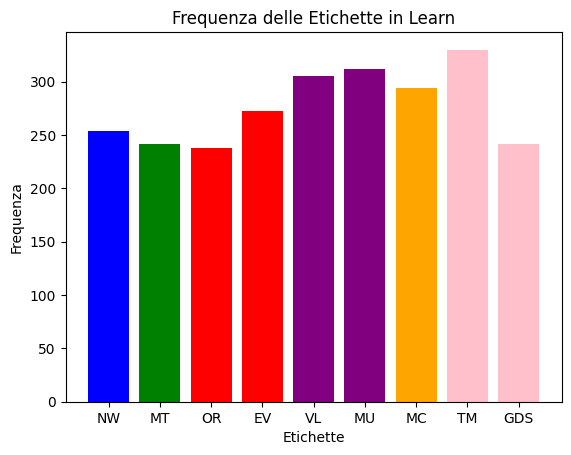

EV: 178
OR: 90
GDS: 90
VL: 30
TM: 79
MU: 62
MT: 98
MC: 77
NW: 30


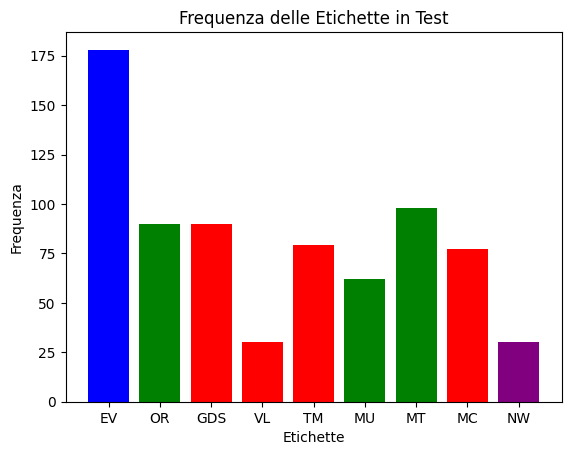

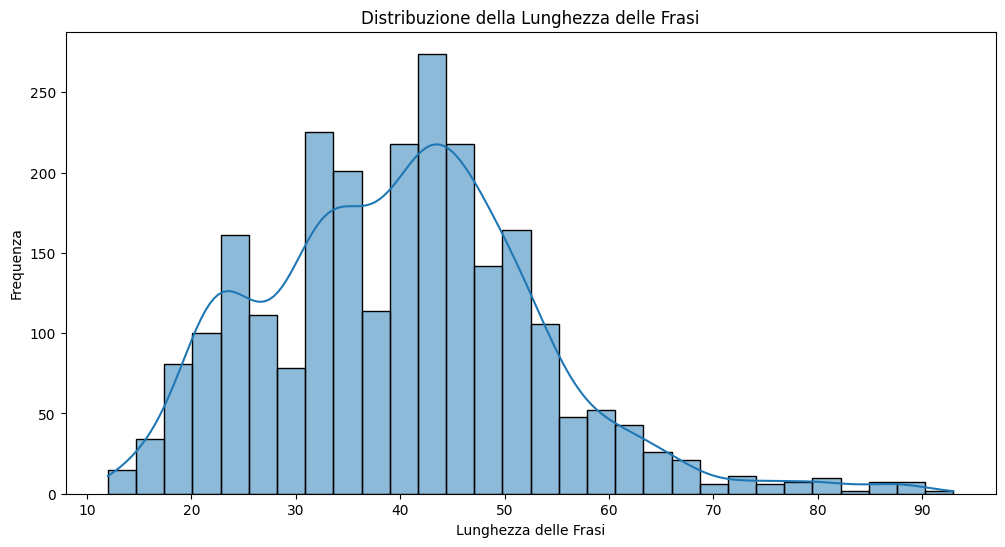

In [4]:

#******************** Training ********************

# Possibili classi (etichette) presenti nei dati
possible_classes = list(set(train_labels))

# Lista di colori corrispondenti alle classi
unique_colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# Calcola la frequenza delle etichette
from collections import Counter
label_counts = Counter(train_labels)

# Estrai le etichette uniche e le relative frequenze
unique_labels = list(label_counts.keys())
frequencies = list(label_counts.values())

for index , value in enumerate(unique_labels):
    print(f"{value}: {frequencies[index]}")
# Crea un dizionario che mappa ciascuna etichetta al suo colore corrispondente
label_to_color = {label: color for label, color in zip(unique_labels, unique_colors)}
# Estrai i colori corrispondenti alle etichette nel tuo dataset
bar_colors = [label_to_color[label] for label in train_labels]
# Crea un grafico a barre con colori diversi per ciascuna colonna
plt.bar(unique_labels, frequencies, color=bar_colors)
# Aggiungi etichette
plt.xlabel('Etichette')
plt.ylabel('Frequenza')
# Aggiungi un titolo
plt.title('Frequenza delle Etichette in Learn')
# Mostra il grafico a barre
plt.show()

# Possibili classi (etichette) presenti nei dati
possible_classes = list(set(test_labels))

# Calcola la frequenza delle etichette
from collections import Counter
label_counts = Counter(test_labels)

# Estrai le etichette uniche e le relative frequenze
unique_labels = list(label_counts.keys())
frequencies = list(label_counts.values())

for index , value in enumerate(unique_labels):
    print(f"{value}: {frequencies[index]}")
    
    
#******************** Test dataset ********************
# Crea un dizionario che mappa ciascuna etichetta al suo colore corrispondente
label_to_color = {label: color for label, color in zip(unique_labels, unique_colors)}
# Estrai i colori corrispondenti alle etichette nel tuo dataset
bar_colors = [label_to_color[label] for label in test_labels]
# Crea un grafico a barre con colori diversi per ciascuna colonna
plt.bar(unique_labels, frequencies, color=bar_colors)
# Aggiungi etichette
plt.xlabel('Etichette')
plt.ylabel('Frequenza')
# Aggiungi un titolo
plt.title('Frequenza delle Etichette in Test')
# Mostra il grafico a barre
plt.show()


#******************** lenght ********************
# Explore the length of sentences in the 'Frasi' column
dataset_training['Frasi_length'] = dataset_training['Frasi'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(dataset_training['Frasi_length'], bins=30, kde=True)
plt.title('Distribuzione della Lunghezza delle Frasi')
plt.xlabel('Lunghezza delle Frasi')
plt.ylabel('Frequenza')
plt.show()

Vectorize all input data for enable the utils

In [5]:
# Create vector TFI
tfidf_vectorizer = TfidfVectorizer(max_features=500,ngram_range=(1,1),norm='l2',use_idf=True)
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features =  tfidf_vectorizer.transform(test_data)


Create and train the model

In [6]:
# Training the model
svm_model = SVC(kernel='linear', probability=True,C=1,degree=2,gamma='scale',shrinking=True)
calibrated_model = CalibratedClassifierCV(svm_model)
calibrated_model.fit(train_features, train_labels)

CalibratedClassifierCV(estimator=SVC(C=1, degree=2, kernel='linear',
                                     probability=True))

First performance calculation by the train and test accuracy


In [7]:
from sklearn.metrics import classification_report


predictions =  calibrated_model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
train_predictions =  calibrated_model.predict(train_features)
train_acc = accuracy_score(train_labels, train_predictions)
svc_report = classification_report(test_labels, predictions)

Confusion matrix

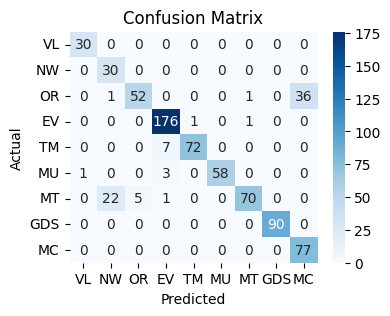

In [8]:
conf_matrix = confusion_matrix(test_labels, predictions, labels=possible_classes)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=possible_classes,
            yticklabels=possible_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Visual reference to the Test and Train accuracy


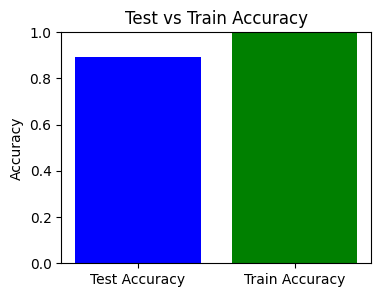

In [9]:
plt.figure(figsize=(4, 3))
plt.bar(['Test Accuracy', 'Train Accuracy'],
        [accuracy, train_acc],
        color=['blue', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Test vs Train Accuracy')
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(bootstrap=True,class_weight=None,criterion='gini',max_depth=None,max_features='auto',min_samples_leaf=1,min_samples_split=2,n_estimators=50,random_state=69)
forest_calibrated_model = CalibratedClassifierCV(forest_model)
forest_calibrated_model.fit(train_features, train_labels)

C:\Users\deadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\deadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\deadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\lo

CalibratedClassifierCV(estimator=RandomForestClassifier(max_features='auto',
                                                        n_estimators=50,
                                                        random_state=69))

In [12]:
from sklearn.metrics import classification_report


predictions =  calibrated_model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
train_predictions =  calibrated_model.predict(train_features)
train_acc = accuracy_score(train_labels, train_predictions)
forest_report = classification_report(test_labels, predictions)

Test pipeline e wordtovector

In [13]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')


import numpy as np

def sentence_to_vec(sentence, model):
    words = sentence.lower().split()
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Esempio
sentence_vec = sentence_to_vec("Esempio di frase", model)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.base import TransformerMixin

class Word2VecVectorizer(TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sentence_to_vec(sentence, self.model) for sentence in X])

word2vec_svc_pipeline = make_pipeline(
    Word2VecVectorizer(model),
    SVC(kernel='linear', probability=True,C=1,degree=2,gamma='scale',shrinking=True)
)

word2vec_svc_pipeline.fit(train_data,train_labels)
score = word2vec_svc_pipeline.score(test_data, test_labels)




In [14]:
model_filename = "F:\ProjectVirgil\VirgilML\\new_start\model\model_eng.pkl"
joblib.dump(word2vec_svc_pipeline, model_filename)

['F:\\ProjectVirgil\\VirgilML\\new_start\\model\\model_eng.pkl']

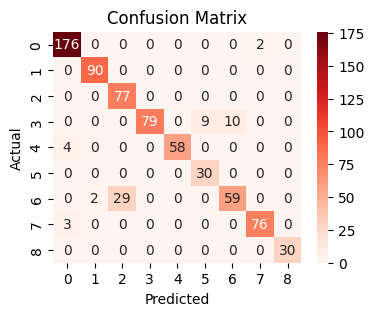

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Effettua le previsioni sul set di test
y_pred = word2vec_svc_pipeline.predict(test_data)

# Calcola e stampa il rapporto di classificazione
word2vec_report = classification_report(test_labels, y_pred)
# Calcola e visualizza la matrice di confusione
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Model Embending

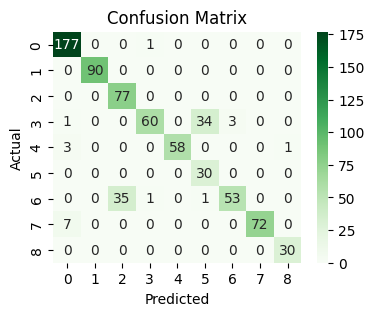

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Definisci i modelli di base
base_learners = [
    ('svc_linear', SVC(kernel='linear', C=1, probability=True)),
    ('svc_rbf', SVC(kernel='rbf', C=1, gamma='auto', probability=True)),
]

# Definisci il meta-learner
meta_learner = LogisticRegression()

# Crea l'ensemble model
ensemble_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Addestra il modello
ensemble_model.fit(train_features, train_labels)
# Valuta il modello

ensemble_score = ensemble_model.score(test_features, test_labels)


# Effettua le previsioni sul set di test
y_pred = ensemble_model.predict(test_features)

# Calcola e stampa il rapporto di classificazione
embed_report = classification_report(test_labels, y_pred)


# Calcola e visualizza la matrice di confusione
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




Manual test all model

In [17]:
from nltk.tokenize import word_tokenize

sentence = "Create a 10-second timer"

filtered_tokens = []

# Tokenizzazione
tokens = word_tokenize(sentence)

# Rimozione di stopwords e altre pulizie
for word in tokens:
    word = word.lower()
    if word not in (",", "?"):
        filtered_tokens.append(word)
        
filtered_tokens = " ".join(filtered_tokens)

In [18]:

prhase_vectorize = tfidf_vectorizer.transform([filtered_tokens])

#SVC
result_svc = calibrated_model.predict(prhase_vectorize)

#WORD2VEC
result_word2vec = word2vec_svc_pipeline.predict([filtered_tokens])

#ESSEMBLE MODEL

result_essemble = ensemble_model.predict(prhase_vectorize)

# FOrest model
result_forest = forest_calibrated_model.predict(prhase_vectorize)

print(f"Frase originale: {sentence}")
print(f"Frase processata: {filtered_tokens}")
print(f"Risultato SVC: {result_svc}")
print(f"Risultato Word2Vec: {result_word2vec}")
print(f"Risultato Ensemble model: {result_essemble}")
print(f"Risultato Forest model: {result_forest}")

from datetime import datetime
# Get the current date and time
current_datetime = datetime.now()
# Format the current date and time as a string
current_datetime_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

with open("F:\ProjectVirgil\VirgilML\\new_start\\result_eng.txt","w")as file:
     
     file.write(f'''
                
{current_datetime_str}

Frase originale: {sentence}    
Frase processata: {filtered_tokens}    
Risultato SVC: {result_svc}
Risultato Word2Vec: {result_word2vec}                
Risultato Ensemble model: {result_essemble}        
Risultato Forest model: {result_forest}     

                                   ---------- REPORT ----------
 
  --- Report svc: ---                                    
 
     {svc_report}                     
  
  --- Report Word2Vec: --- [BEST]
  
     {word2vec_report}                     
  
  --- Report Embed ---                                                                                                                        
     {embed_report}      
     
   --- Report Forest ---
                                                                                                                           
   {forest_report}                                                                                                                      
                ''')




Frase originale: Create a 10-second timer
Frase processata: create a 10-second timer
Risultato SVC: ['TM']
Risultato Word2Vec: ['TM']
Risultato Ensemble model: ['TM']
Risultato Forest model: ['TM']


Grid Search 2.0 time of esecution 256 minuts (3.7 hours)

In [19]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Create a pipeline with TF-IDF vectorizer and SVC model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [500, 1000, 2000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__class_weight': [None, 'balanced'],
    'clf__random_state': [69]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# Assume train_data and train_labels are your training data and labels
X_train, y_train = train_data, train_labels

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

"from sklearn.svm import SVC\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import classification_report\n\n# Create a pipeline with TF-IDF vectorizer and SVC model\npipeline = Pipeline([\n    ('tfidf', TfidfVectorizer()),\n    ('clf', RandomForestClassifier())\n])\n\n# Define the parameter grid for GridSearchCV\nparam_grid = {\n    'tfidf__max_features': [500, 1000, 2000, None],\n    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],\n    'tfidf__use_idf': [True, False],\n    'tfidf__norm': ['l1', 'l2'],\n    'clf__n_estimators': [10, 50, 100, 200],\n    'clf__criterion': ['gini', 'entropy'],\n    'clf__max_depth': [None, 10, 20, 30],\n    'clf__min_samples_split': [2, 5, 10],\n    'clf__min_samples_leaf': [1, 2, 4],\n    'clf__max_features': ['auto', 'sqrt', 'log2'],\n    'clf__bootstrap': [True, False],\n    'clf__class_weight': [None, 'balanced'],\n    'clf__random_state': [69]\n}\n\n# Initialize GridSearchCV\ngrid_search